### Exploración de los datos

### Verificación los datos nulos

In [3]:
# Importación de librerías y configuración de entorno
import os
import sys
import pandas as pd
import numpy as np
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt

def get_required_env(var_name):
    value = os.environ.get(var_name)
    if not value:
        print(f"FATAL ERROR: La variable de entorno requerida '{var_name}' no está configurada o es nula.", file=sys.stderr)
        sys.exit(1)
    return value

BUCKET_NAME_BRONZE = get_required_env("BUCKET_NAME_BRONZE")
AWS_ACCESS_KEY_ID = get_required_env("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = get_required_env("AWS_SECRET_ACCESS_KEY")

In [4]:
TARGET_COUNTRIES = ['MEX', 'ARG']
# Rango de años a incluir (2019 a 2024, el 2025 es exclusivo)
YEARS_RANGE = range(2019, 2025)

PATHS = {
    'jmp': 's3://henry-pf-g2-huella-hidrica/bronze/jmp/ingest_date=20251118/JMP_LATAM_2019_2024.csv',
    # La ruta de WDI será generada dinámicamente
    'climate_agg': 's3://henry-pf-g2-huella-hidrica/bronze/open_meteo/aggregated_annual_precipitation.parquet' 
}

# DICCIONARIOS DE MAPEO DE COLUMNAS

JMP_COLUMNS_MAPPING = {
    'ISO3': 'country_iso3', 'Country': 'country_name', 'Residence Type': 'residence_type',
    'Service Type': 'service_type', 'Service level': 'service_level',
    'Coverage': 'coverage_pct', 'Year': 'year', 'Population': 'population'
}

WDI_PIVOT_MAPPING = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita_usd_current',
    'SI.POV.DDAY': 'poverty_headcount',
    'SH.STA.SMSS.ZS': 'safely_managed_sanitation_pct',
    'SH.DYN.MORT': 'under5_mortality_per_1000' 
}

## PREPARACIÓN Y UNIFICACIÓN DE DATOS

print(f"--- 🛠️ FASE 1: Preparación de Datos para años {YEARS_RANGE.start} a {YEARS_RANGE.stop - 1} ---")

# 1. CARGA Y LIMPIEZA DE DATOS JMP
df_jmp_raw = pd.read_csv(PATHS['jmp'], storage_options={'anon': False})
df_jmp_raw.rename(columns=JMP_COLUMNS_MAPPING, inplace=True)

df_jmp_filtered = df_jmp_raw[
    (df_jmp_raw['country_iso3'].isin(TARGET_COUNTRIES)) & 
    (df_jmp_raw['year'].isin(YEARS_RANGE))
].copy()


# 2. CARGA Y LIMPIEZA DE DATOS WORLD BANK (WDI) - CARGA DINÁMICA
print("Generando rutas de WDI y cargando datos...")
wdi_files = []
for country in TARGET_COUNTRIES:
    for year in YEARS_RANGE:
        # Construye la ruta S3 para cada país y año
        path = f"s3://henry-pf-g2-huella-hidrica/bronze/world_bank/country={country}/year={year}/world_bank.parquet"
        wdi_files.append(path)

try:
    df_wdi = pd.concat([pd.read_parquet(f, storage_options={'anon': False}) for f in wdi_files])
except ValueError as e:
    print(f"ERROR: Fallo al concatenar archivos WDI. Detalles: {e}")
    df_wdi = pd.DataFrame(columns=['country_code', 'year', 'indicator_code', 'value']) 

# Proceso de Limpieza y Pivotaje (para convertir el formato largo a ancho)
df_wdi.rename(columns={'country_code': 'country_iso3'}, inplace=True) 

df_wdi_wide = df_wdi.pivot_table(
    index=['country_iso3', 'year'],
    columns='indicator_code',
    values='value'
).reset_index()

cols_to_rename = {k: v for k, v in WDI_PIVOT_MAPPING.items() if k in df_wdi_wide.columns}
df_wdi_wide.rename(columns=cols_to_rename, inplace=True) 

df_wdi_wide['year'] = df_wdi_wide['year'].astype(int) 

WDI_COLS_FINAL = [
    'country_iso3', 'year', 'gdp_per_capita_usd_current', 'poverty_headcount', 
    'safely_managed_sanitation_pct', 'under5_mortality_per_1000'
]

cols_exist = [col for col in WDI_COLS_FINAL if col in df_wdi_wide.columns]
df_wdi = df_wdi_wide[cols_exist]

missing_cols = set(WDI_COLS_FINAL) - set(df_wdi.columns)
if missing_cols:
    print(f"\n⚠️ ADVERTENCIA WDI: Faltan columnas: {missing_cols}")
    
print("\n✅ DataFrame WDI (Ancho) listo. Filas:", len(df_wdi))


# 3. CARGA DE DATOS CLIMÁTICOS (Placeholder)
try:
    df_climate = pd.read_parquet(PATHS['climate_agg'], storage_options={'anon': False})
    df_climate = df_climate[
        (df_climate['country_iso3'].isin(TARGET_COUNTRIES)) & 
        (df_climate['year'].isin(YEARS_RANGE))
    ].copy()
    df_climate.rename(columns={'precipitation_sum_mm_annual': 'precipitation_sum_mm'}, inplace=True)
except Exception:
    print("ADVERTENCIA: Archivo de clima agregado no encontrado. Creando datos simulados multi-año.")
    data = []
    for country in TARGET_COUNTRIES:
        for year in YEARS_RANGE:
            data.append({
                'country_iso3': country,
                'year': year,
                'precipitation_sum_mm': np.random.uniform(700, 1000) 
            })
    df_climate = pd.DataFrame(data)


# 4. UNIFICACIÓN DE DATOS BASE
df_base = pd.merge(df_jmp_filtered, df_wdi, on=['country_iso3', 'year'], how='left')
df_base = pd.merge(df_base, df_climate, on=['country_iso3', 'year'], how='left')

print("\n✅ DataFrame Base Creado. Filas totales:", len(df_base))
print(df_base.info())

--- 🛠️ FASE 1: Preparación de Datos para años 2019 a 2024 ---
Generando rutas de WDI y cargando datos...

⚠️ ADVERTENCIA WDI: Faltan columnas: {'safely_managed_sanitation_pct'}

✅ DataFrame WDI (Ancho) listo. Filas: 12
ADVERTENCIA: Archivo de clima agregado no encontrado. Creando datos simulados multi-año.

✅ DataFrame Base Creado. Filas totales: 240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country_iso3                240 non-null    object 
 1   country_name                240 non-null    object 
 2   residence_type              240 non-null    object 
 3   service_type                240 non-null    object 
 4   year                        240 non-null    int64  
 5   coverage_pct                240 non-null    float64
 6   population                  240 non-null    float64
 7   service_level           

In [5]:
# 📊 FASE 2: ANÁLISIS DESCRIPTIVO Y TENDENCIAS

print("\n\n--- 📈 FASE 2: Análisis de Tendencias Anuales ---")

# 1. Preparación de datos agregados (Water Safety)
df_water_safe = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Safely managed service') &
    (df_base['residence_type'] == 'total') # Usamos la cobertura total
][['country_name', 'year', 'coverage_pct']].copy()
df_water_safe.rename(columns={'coverage_pct': 'P1_Agua_Segura_Pct'}, inplace=True)


# 2. Cálculo y Tendencia del Indicador P2 (Población Limitada)
# P2: Población absoluta con servicio limitado de agua
df_p2_trend = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Limited service')
].copy()

# Calcular la población absoluta afectada por país y año
df_p2_trend['affected_population'] = (df_p2_trend['population'] * df_p2_trend['coverage_pct']) / 100
df_p2_trend = df_p2_trend.groupby(['country_name', 'year'])['affected_population'].sum().reset_index()
df_p2_trend.rename(columns={'affected_population': 'P2_Pob_Lim_Agua_Abs'}, inplace=True)


# 3. Cálculo y Tendencia del Indicador P3 (Alto Riesgo Sanitario)
# P3: Porcentaje en Alto Riesgo Sanitario (Suma de coberturas Limited, Unimproved, Open defecation)
RISK_LEVELS = ['Limited service', 'Unimproved', 'Open defecation']
df_p3_raw = df_base[
    (df_base['service_type'] == 'Sanitation') & 
    (df_base['service_level'].isin(RISK_LEVELS))
].copy()

# Agrega la cobertura de los tres niveles de riesgo por país y año
df_p3_trend = df_p3_raw.groupby(['country_name', 'year'])['coverage_pct'].sum().reset_index()
df_p3_trend.rename(columns={'coverage_pct': 'P3_Alto_Riesgo_San_Pct'}, inplace=True)

print("\nDatos de P3 Agregados (Primeras 5 filas):")
print(df_p3_trend.head())



--- 📈 FASE 2: Análisis de Tendencias Anuales ---

Datos de P3 Agregados (Primeras 5 filas):
  country_name  year  P3_Alto_Riesgo_San_Pct
0    Argentina  2019                 2.48772
1    Argentina  2020                 2.31668
2    Argentina  2021                 1.64059
3    Argentina  2022                 1.53040
4    Argentina  2023                 1.53040


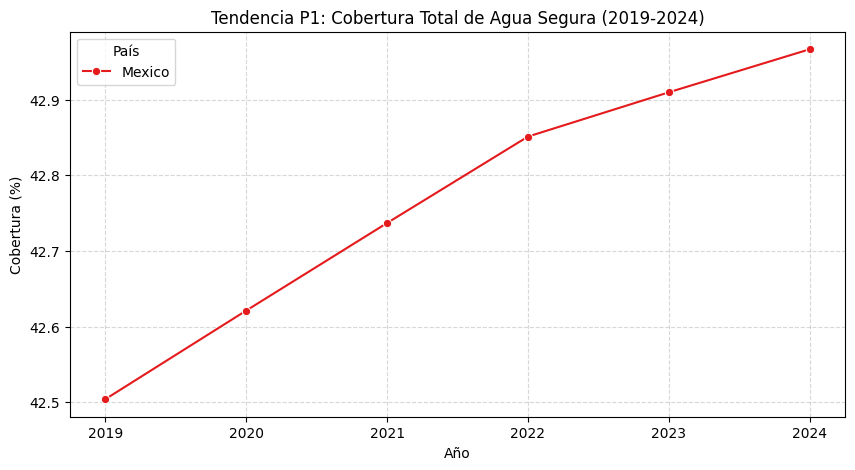

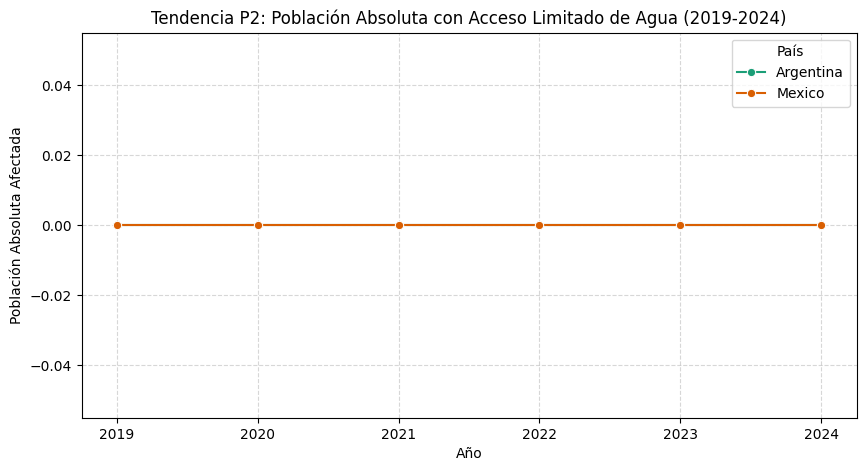

In [6]:
# VISUALIZACIÓN DE TENDENCIAS


# Tendencia P1: Cobertura de Agua Segura (Safely managed) 
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_water_safe,
    x='year',
    y='P1_Agua_Segura_Pct',
    hue='country_name',
    marker='o',
    palette='Set1'
)
plt.title('Tendencia P1: Cobertura Total de Agua Segura (2019-2024)')
plt.xlabel('Año')
plt.ylabel('Cobertura (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='País')
plt.xticks(df_water_safe['year'].unique())
plt.show()


# Tendencia P2: Población Absoluta con Servicio Limitado de Agua 
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_p2_trend,
    x='year',
    y='P2_Pob_Lim_Agua_Abs',
    hue='country_name',
    marker='o',
    palette='Dark2'
)
plt.title('Tendencia P2: Población Absoluta con Acceso Limitado de Agua (2019-2024)')
plt.xlabel('Año')
plt.ylabel('Población Absoluta Afectada')
# Formateo para números grandes
plt.ticklabel_format(style='plain', axis='y') 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='País')
plt.xticks(df_p2_trend['year'].unique())
plt.show()

In [7]:
print("DataFrame de Tendencia P2:")
print(df_p2_trend)

DataFrame de Tendencia P2:
   country_name  year  P2_Pob_Lim_Agua_Abs
0     Argentina  2019                  0.0
1     Argentina  2020                  0.0
2     Argentina  2021                  0.0
3     Argentina  2022                  0.0
4     Argentina  2023                  0.0
5     Argentina  2024                  0.0
6        Mexico  2019                  0.0
7        Mexico  2020                  0.0
8        Mexico  2021                  0.0
9        Mexico  2022                  0.0
10       Mexico  2023                  0.0
11       Mexico  2024                  0.0


In [8]:
# Crear un DataFrame booleano (True si es nulo)
df_null_bool = df_base.isnull()

# Agrupar por año y sumar (True=1, False=0) para obtener el conteo de nulos por columna, por año
df_null_count_by_year = df_null_bool.groupby('year').sum()

print("\n--- Conteo de Nulos Agregado por Año ---")
print(df_null_count_by_year)


--- Conteo de Nulos Agregado por Año ---
       country_iso3  country_name  residence_type  service_type  coverage_pct  \
year                                                                            
False             0             0               0             0             0   

       population  service_level  gdp_per_capita_usd_current  \
year                                                           
False           0              0                           0   

       poverty_headcount  under5_mortality_per_1000  precipitation_sum_mm  
year                                                                       
False                126                         39                     0  



--- Visualización de Nulos (Matriz) ---


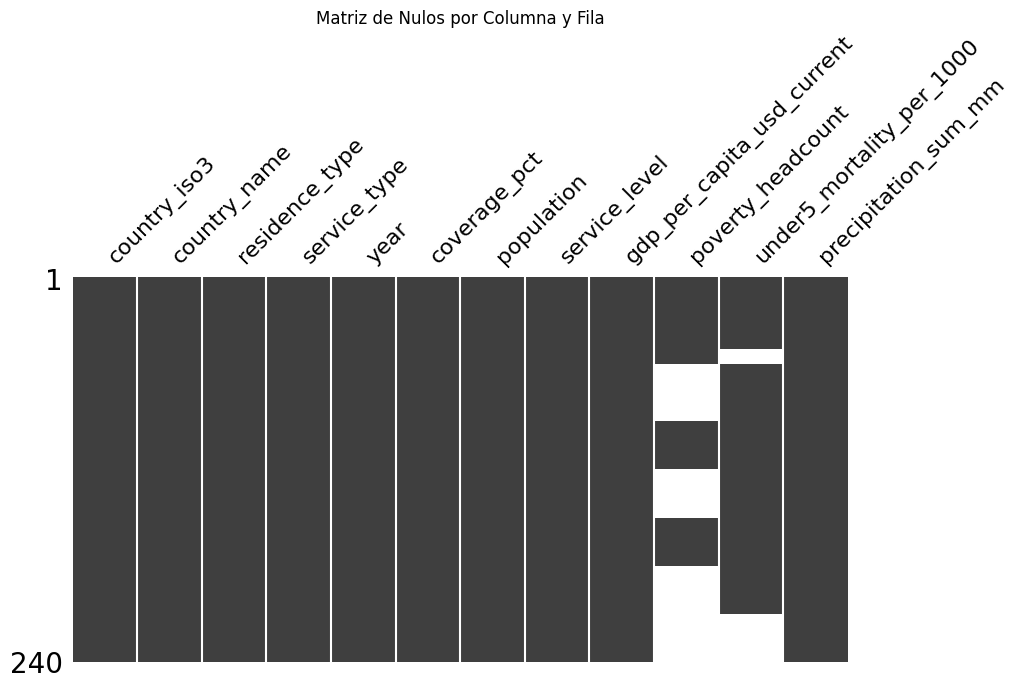


--- Porcentaje de Datos Existentes por Columna ---


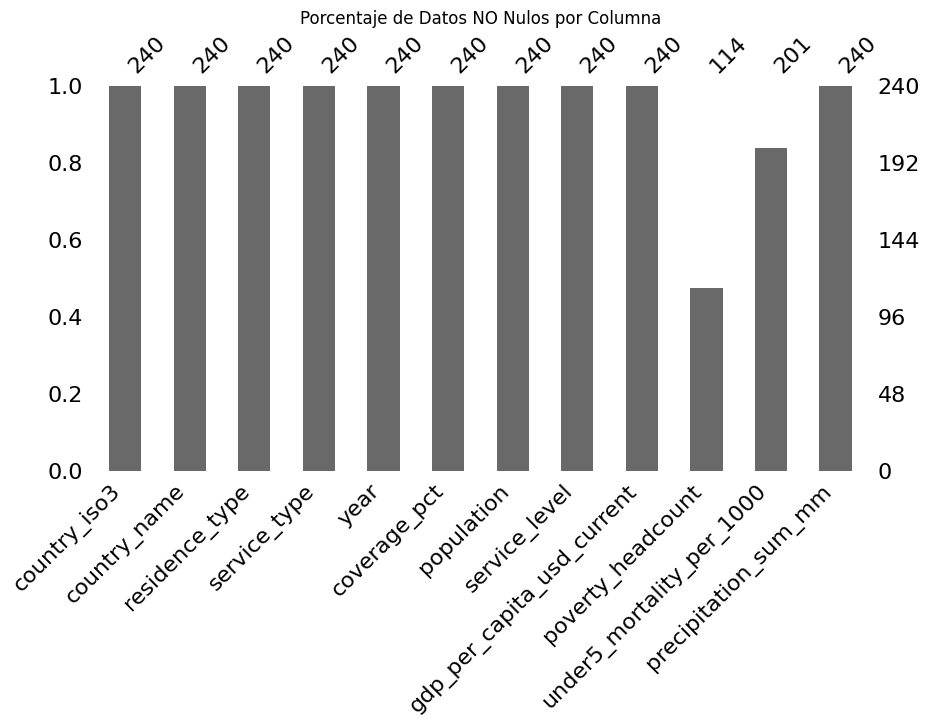

In [9]:
import missingno as msno 

# Gráfico de matriz: Visualiza la densidad de datos por fila (muestra dónde faltan datos)
print("\n--- Visualización de Nulos (Matriz) ---")
msno.matrix(df_base.sort_values(by=['country_iso3', 'year']), figsize=(10, 5), sparkline=False)
plt.title('Matriz de Nulos por Columna y Fila')
plt.show()

# Gráfico de barras: Muestra el porcentaje de datos existentes por columna 
print("\n--- Porcentaje de Datos Existentes por Columna ---")
msno.bar(df_base, figsize=(10, 5))
plt.title('Porcentaje de Datos NO Nulos por Columna')
plt.show()

In [10]:
# Estadísticas descriptivas de variables críticas
print("--- Estadísticas Descriptivas (Variables Clave) ---")
print(df_base[['coverage_pct', 'gdp_per_capita_usd_current', 'poverty_headcount', 'precipitation_sum_mm']].describe().T)

--- Estadísticas Descriptivas (Variables Clave) ---
                            count          mean          std          min  \
coverage_pct                240.0     27.344623    37.008795     0.000000   
gdp_per_capita_usd_current  240.0  11543.536513  1992.223250  8535.599380   
poverty_headcount           114.0      2.431579     1.203778     1.000000   
precipitation_sum_mm        240.0    868.145320   108.430846   704.138503   

                                     25%           50%           75%  \
coverage_pct                    0.000000      2.701570     53.460588   
gdp_per_capita_usd_current  10314.050673  10738.017922  13826.130657   
poverty_headcount               1.400000      2.300000      4.300000   
precipitation_sum_mm          729.986882    920.110749    960.346350   

                                     max  
coverage_pct                  100.000000  
gdp_per_capita_usd_current  14187.482725  
poverty_headcount               4.300000  
precipitation_sum_mm         

In [11]:
# Pivoteo para comparar la cobertura de agua segura (Safely managed)
df_residence_pivot = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Safely managed service')
].pivot_table(
    index=['country_name', 'year'],
    columns='residence_type',
    values='coverage_pct'
)

print("\n--- Cobertura de Agua Segura (Urbano vs. Rural) ---")
print(df_residence_pivot)


--- Cobertura de Agua Segura (Urbano vs. Rural) ---
residence_type        total
country_name year          
Mexico       2019  42.50394
             2020  42.62107
             2021  42.73688
             2022  42.85114
             2023  42.90972
             2024  42.96663


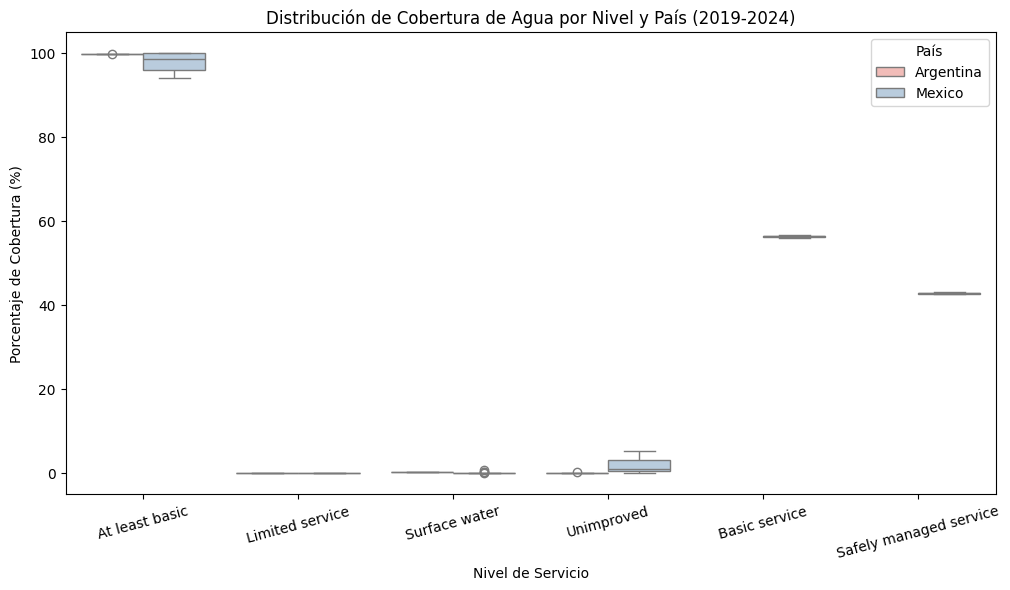

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de la Cobertura Hídrica por Nivel de Servicio 
plt.figure(figsize=(12, 6))
df_temp = df_base[df_base['service_type'] == 'Drinking water']
sns.boxplot(
    data=df_temp,
    x='service_level',
    y='coverage_pct',
    hue='country_name',
    palette='Pastel1'
)
plt.title('Distribución de Cobertura de Agua por Nivel y País (2019-2024)')
plt.xlabel('Nivel de Servicio')
plt.ylabel('Porcentaje de Cobertura (%)')
plt.xticks(rotation=15)
plt.legend(title='País')
plt.show()

In [13]:
# Filtramos solo los datos de Argentina para Agua Potable
df_arg_debug = df_base[
    (df_base['country_name'] == 'Argentina') & 
    (df_base['service_type'] == 'Drinking water')
]

# Vemos las estadísticas por nivel de servicio
print("--- Estadísticas de Cobertura de Agua: Argentina (2019-2024) ---")
# El describe() nos mostrará el conteo (count), media (mean) y desviación (std)
print(df_arg_debug.groupby('service_level')['coverage_pct'].describe())

--- Estadísticas de Cobertura de Agua: Argentina (2019-2024) ---
                 count       mean       std       min       25%       50%  \
service_level                                                               
At least basic     6.0  99.808045  0.022695  99.76172  99.81731  99.81731   
Limited service    6.0   0.000000  0.000000   0.00000   0.00000   0.00000   
Surface water      6.0   0.118570  0.000000   0.11857   0.11857   0.11857   
Unimproved         6.0   0.073385  0.022695   0.06412   0.06412   0.06412   

                      75%       max  
service_level                        
At least basic   99.81731  99.81731  
Limited service   0.00000   0.00000  
Surface water     0.11857   0.11857  
Unimproved        0.06412   0.11971  


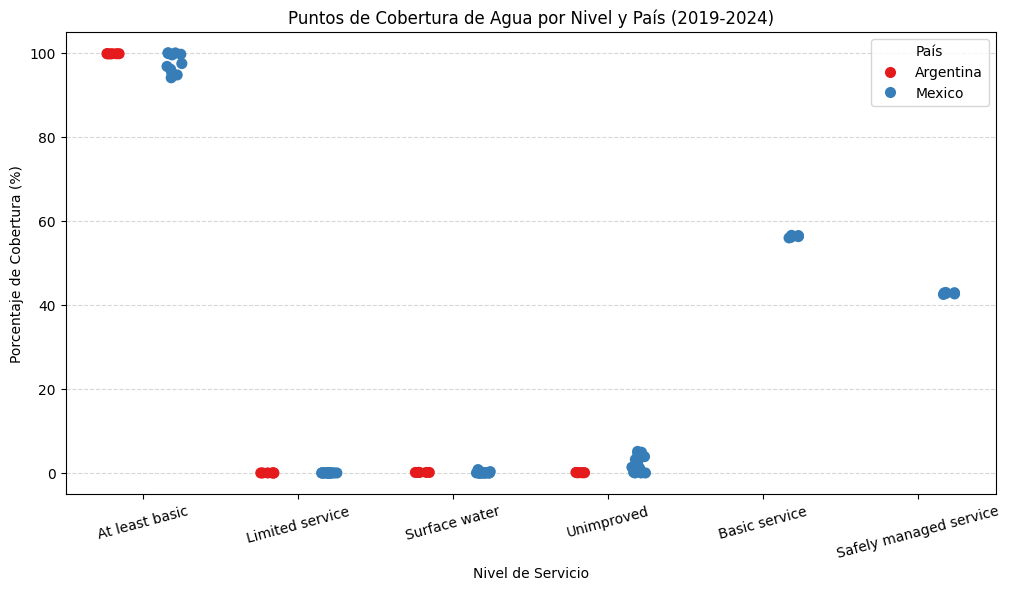

In [ ]:
plt.figure(figsize=(12, 6))

sns.stripplot(
    data=df_temp,
    x='service_level',
    y='coverage_pct',
    hue='country_name',
    dodge=True, 
    palette='Set1',
    s=8 
)

plt.title('Puntos de Cobertura de Agua por Nivel y País (2019-2024)')
plt.xlabel('Nivel de Servicio')
plt.ylabel('Porcentaje de Cobertura (%)')
plt.xticks(rotation=15)
plt.legend(title='País')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

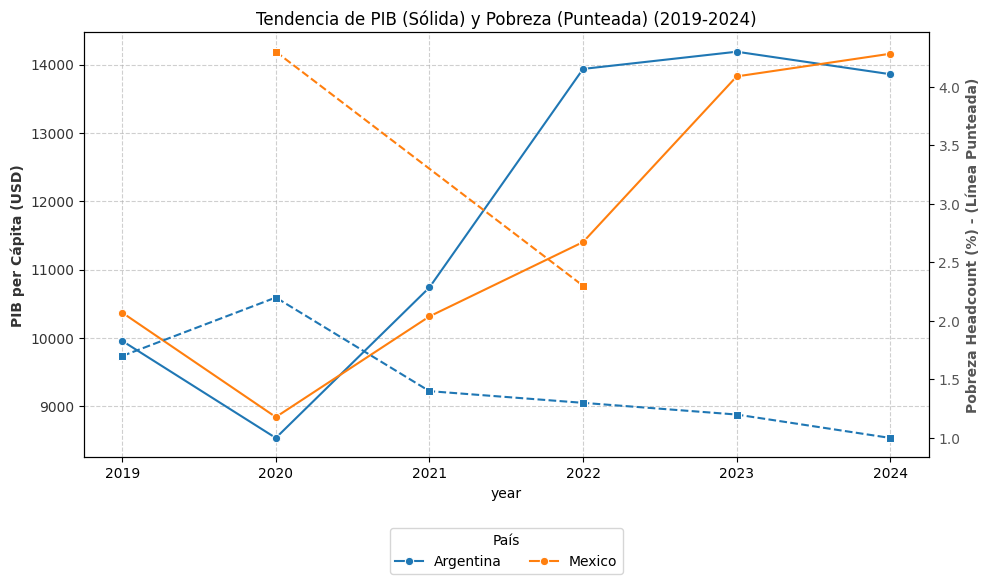

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

colores_paises = {'Argentina': '#1f77b4', 'Mexico': '#ff7f0e'} # Azul y Naranja estándar

df_econ = df_base[['country_name', 'year', 'gdp_per_capita_usd_current', 'poverty_headcount']].drop_duplicates()

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- GRÁFICO 1: PIB (Eje Izquierdo) - LÍNEA SÓLIDA ---
sns.lineplot(
    data=df_econ, 
    x='year', 
    y='gdp_per_capita_usd_current', 
    hue='country_name', 
    ax=ax1, 
    marker='o', 
    palette=colores_paises,
    legend=True
)

ax1.set_ylabel('PIB per Cápita (USD)', color='#333333', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#333333')
ax1.grid(True, linestyle='--', alpha=0.6)

# --- GRÁFICO 2: POBREZA (Eje Derecho)
ax2 = ax1.twinx()
sns.lineplot(
    data=df_econ, 
    x='year', 
    y='poverty_headcount', 
    hue='country_name', 
    ax=ax2, 
    marker='s', 
    linestyle='--',
    palette=colores_paises,
    legend=False
)

ax2.set_ylabel('Pobreza Headcount (%) - (Línea Punteada)', color='#555555', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#555555')

plt.title('Tendencia de PIB (Sólida) y Pobreza (Punteada) (2019-2024)')
plt.xticks(df_econ['year'].unique())

sns.move_legend(ax1, "upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, title='País')

plt.tight_layout()
plt.show()

In [19]:
# Verificamos qué datos existen para México desde 2021 en adelante
print("--- Datos de México (2021-2024) ---")
cols_check = ['year', 'gdp_per_capita_usd_current', 'poverty_headcount']
df_mx_check = df_base[df_base['country_name'] == 'Mexico'][cols_check].drop_duplicates().sort_values('year')

print(df_mx_check)

--- Datos de México (2021-2024) ---
     year  gdp_per_capita_usd_current  poverty_headcount
54   2019                10369.555359                NaN
90   2020                 8841.270751                4.3
120  2021                10314.050673                NaN
150  2022                11402.141037                2.3
180  2023                13826.130657                NaN
210  2024                14157.944584                NaN
